# Clustering test 1 - Customer segmentation
# Robert Long 01-04-2023
### Dataset - online retailor transaction from 2010-2011
### Method - K-means algorithm
### Visualisation - scatter plots
### Conclusions - types of customer and business suggestions

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# read-in the excel spreadsheet using pandas 
df = pd.read_excel('Online_retail.xlsx', sheet_name='Online Retail')

df.head() # take a look at the first 5 rows in the DataFrame


#Dataset contains transactions occuring between 2010-2011 for UK based online retail store
#Source : Dr. Chen, Engineering, London South Bank University
#http://archive.ics.uci.edu/ml/datasets/online+retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Clean the data

In [10]:
# Remove  cancelled orders
df = df.loc[df['Quantity'] > 0]

# Remove any entries without CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Remove incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

## Aggregate and transform data

In [11]:
# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns of interest
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValue'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

# customer_df.head()


## Normalise data
### K-means are sensitive to scales of data

In [12]:

rank_df = customer_df.rank(method='first')
# normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df =  2* (rank_df - rank_df.mean()) / (rank_df.max() - rank_df.min())
# normalized_df.head(10)

## Determine how many clusters

Silhouette Score for 2 Clusters: 0.4288
Silhouette Score for 3 Clusters: 0.4133
Silhouette Score for 4 Clusters: 0.4117
Silhouette Score for 5 Clusters: 0.3779
Silhouette Score for 6 Clusters: 0.3807
Silhouette Score for 7 Clusters: 0.3913
Silhouette Score for 8 Clusters: 0.3811
Silhouette Score for 9 Clusters: 0.3764
Silhouette Score for 10 Clusters: 0.3619


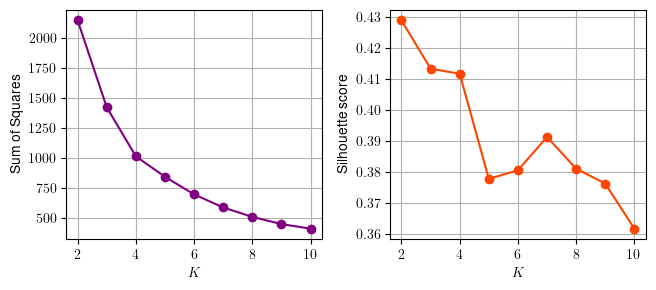

In [13]:
from sklearn import cluster
import numpy as np

sse = []
krange = list(range(2,11))
X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))


def plot_n(x,y, ytitle, col):
    plt.plot(x,y, 'o-', color=col)
    plt.xlabel("$K$")
    plt.ylabel(ytitle)
    plt.grid()

# Use silhouette coefficient to determine the best number of clusters
from sklearn.metrics import silhouette_score

sse_si = []
for n_cluster in krange:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_)   
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
    sse_si.append(silhouette_avg)
    
plt.figure(figsize=(6.66,3),dpi=100)
plt.subplot(1,2,1)
plot_n(krange, sse, "Sum of Squares", "purple")
plt.subplot(1,2,2)
plot_n(krange, sse_si, "Silhouette score", "orangered")
plt.tight_layout()
plt.show()


## Interpret customer segments

In [14]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_
#four_cluster_df.head(10)

cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]


data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
#cluster_center_df

## Visualise clusters

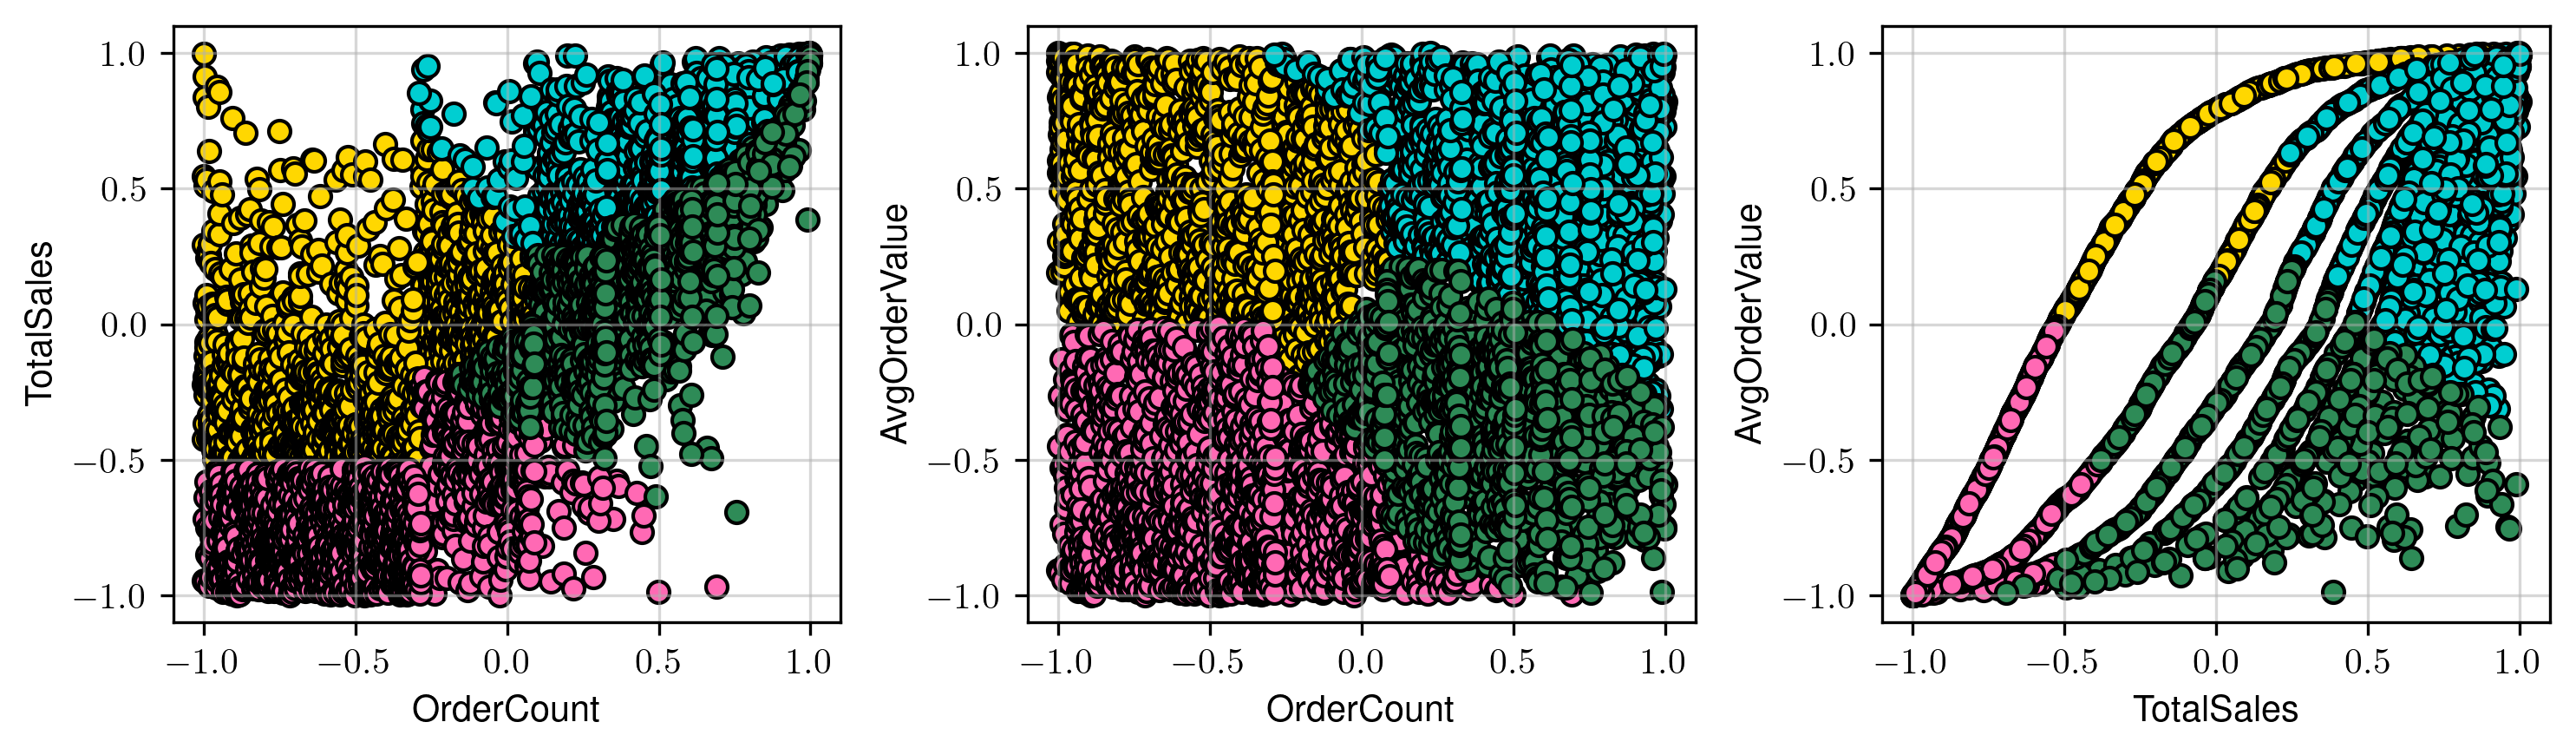

In [15]:
scatval = [0,1,2,3]; scatcol = ['gold','darkturquoise','hotpink','seagreen']

def scat(index, xtitle, ytitle):
    plt.scatter(
        four_cluster_df.loc[four_cluster_df['Cluster'] == scatval[index]][xtitle], 
        four_cluster_df.loc[four_cluster_df['Cluster'] == scatval[index]][ytitle],
        c= scatcol[index], edgecolor='k')

def plot_scat(index, xtitle, ytitle):
    for i in index :
        scat(index[i], xtitle, ytitle)
    # plt.title('TotalSales vs. OrderCount Clusters')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.axis([-1.1,1.1,-1.1,1.1])
    plt.grid(alpha=0.5)
   


plt.figure(figsize=(10,3), dpi=300)
plt.subplot(1,3,1)
plot_scat([0,1,2,3], 'OrderCount', 'TotalSales')
plt.subplot(1,3,2)
plot_scat([0,1,2,3], 'OrderCount', 'AvgOrderValue')
plt.subplot(1,3,3)
plot_scat([0,1,2,3], 'TotalSales', 'AvgOrderValue')
plt.tight_layout()
plt.show()

## Find best selling item for each cluster

In [16]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 1]

pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby(
    'Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
JUMBO BAG RED RETROSPOT,1129
REGENCY CAKESTAND 3 TIER,1082
WHITE HANGING HEART T-LIGHT HOLDER,1062
LUNCH BAG RED RETROSPOT,924
PARTY BUNTING,859
